<a href="https://colab.research.google.com/github/park-geun-hyeong/Computer_Vision/blob/main/Dacon/LG_AI_Contest/Augmentation_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
!pip install albumentations==0.4.6

import os 
from glob import glob
import json
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('whitegrid')

import albumentations as A
from albumentations.pytorch.transforms import ToTensor
from albumentations.pytorch.transforms import ToTensorV2

from tqdm import tqdm
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import models


from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

path = '/content/drive/MyDrive/Dacon'
os.chdir(path)

In [3]:
def fix(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.daterministic=True
  torch.backends.cudnn.benchmark=False
  np.random.seed(seed)
  random.seed(seed)

fix(42)

In [4]:
sample = sorted(os.listdir(path + '/train'))

In [5]:
train_label = pd.read_csv(path + '/train.csv')
label_kind = np.unique(train_label.label.values).tolist()
label_to_idx = {i:idx for idx, i in enumerate(label_kind)}
idx_to_label = {idx:i for idx, i in enumerate(label_kind)}

In [6]:
with open(path + '/feature_min_max.json', 'r') as f:
  csv_feature_dict = json.load(f)

csv_feature_dict 

{'내부 습도 1 최고': {'MAX': 100.0, 'MIN': 25.9},
 '내부 습도 1 최저': {'MAX': 100.0, 'MIN': 22.0},
 '내부 습도 1 평균': {'MAX': 100.0, 'MIN': 23.7},
 '내부 온도 1 최고': {'MAX': 47.6, 'MIN': 3.4},
 '내부 온도 1 최저': {'MAX': 47.0, 'MIN': 3.3},
 '내부 온도 1 평균': {'MAX': 47.3, 'MIN': 3.4},
 '내부 이슬점 최고': {'MAX': 34.7, 'MIN': 0.2},
 '내부 이슬점 최저': {'MAX': 34.4, 'MIN': 0.0},
 '내부 이슬점 평균': {'MAX': 34.5, 'MIN': 0.1}}

In [7]:
kfold = StratifiedKFold(n_splits=10)
train_label['fold'] = -1

for idx, (tr_idx, val_idx) in enumerate(kfold.split(train_label.image.values, train_label.label.values)):
  train_label.loc[val_idx, 'fold'] = idx

val_idx = list(train_label[train_label.fold == 9].index) + list(train_label[train_label.fold == 10].index)
train_idx = set(train_label.index) - set(val_idx)

train_idx = sorted(list(train_idx))
val_idx = sorted(list(val_idx))

train_df = train_label.loc[train_idx].reset_index(drop=True)
val_df = train_label.loc[val_idx].reset_index(drop=True)

## Define Transform

In [8]:
pixel_transform = A.Compose([
                            A.Resize(256,256, interpolation = cv2.INTER_AREA,always_apply=True),
                            A.OneOf([
                                     A.IAAAdditiveGaussianNoise(p = 0.5),
                                     A.GaussNoise(p = 0.5)
                            ], p = 0.2),
                            A.OneOf([
                                     A.MotionBlur(p = 0.2),
                                     A.MedianBlur(blur_limit=3, p=0.1),
                                     A.Blur(blur_limit=3, p=0.1)
                            ], p = 0.2),
                            A.OneOf([
                                    A.CLAHE(clip_limit = 2),
                                     A.IAASharpen(),
                                     A.IAAEmboss(),
                                     A.RandomBrightnessContrast()
                            ], p =0.3),
                            A.HueSaturationValue(p=0.3),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()
])


spatial_transform = A.Compose([
                              A.Resize(256,256, interpolation = cv2.INTER_AREA,always_apply=True),
                              A.OneOf([
                                       A.HorizontalFlip(),
                                       A.VerticalFlip()
                              ], p = 0.2),
                              A.OneOf([
                                       A.RandomRotate90(),
                                       A.Transpose(),
                                       A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
                              ], p = 0.3),
                              A.OneOf([
                                      A.OpticalDistortion(p=0.3),
                                      A.GridDistortion(p=.1),
                                      A.IAAPiecewiseAffine(p=0.3),
                                 ], p=0.2),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()
                                      
])


pixel_spatial_transform = A.Compose([
                                     A.Resize(256,256, interpolation = cv2.INTER_AREA,always_apply=True),
                                     A.OneOf([
                                        A.HorizontalFlip(),
                                        A.VerticalFlip()
                                      ], p = 0.2),
                                     A.OneOf([
                                          A.RandomRotate90(),
                                          A.Transpose(),
                                          A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
                                      ], p = 0.3),
                                     A.OneOf([
                                            A.CLAHE(clip_limit = 2),
                                            A.IAASharpen(),
                                            A.IAAEmboss(),
                                            A.RandomBrightnessContrast()
                                      ], p =0.3),
                                     
                                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                                ToTensorV2()


])

In [9]:
path = '/content/drive/MyDrive/Dacon'
class LGDataset(Dataset):
  def __init__(self, file_df,transform = None):
    self.file_df = file_df
    self.path = path
    self.transform = transform
    self.csv_feature_dict = csv_feature_dict
    self.max_len = 196
    self.label_to_idx = label_to_idx

  def __len__(self):
    return self.file_df.shape[0]

  def __getitem__(self, idx):
    image_name = int(self.file_df.iloc[idx, 0])
    img_path = os.path.join(self.path, f'train/{image_name}/{image_name}.jpg')
    label = str(self.file_df.iloc[idx, 1])

    csv_path = os.path.join(self.path, f"train/{image_name}/{image_name}.csv")
    df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
    df = df.replace('-', np.nan)
    df.fillna(method = 'pad')

    for col in self.csv_feature_dict.keys():
      df[col] = df[col].astype(float) - self.csv_feature_dict[col]['MIN']
      df[col][df[col] < 0] = 0
      df[col] = df[col] / (self.csv_feature_dict[col]['MAX'] - self.csv_feature_dict[col]['MIN'])

    pad = np.zeros((self.max_len, len(df.columns)))
    length = min(len(df), self.max_len)
    pad[-length:] = df.to_numpy()[-length:]
    csv_feature = pad.T

    img = cv2.imread(img_path)
    if self.transform is not None:
      img = self.transform(image = img)['image']
      
    csv_feature = torch.tensor(csv_feature, dtype=torch.float32)
    label = torch.tensor(self.label_to_idx[label], dtype=torch.long)

    return {
      'img': img,
      'csv_feature': csv_feature,
      'label': label
    }

In [10]:
pixel_transform_dataset = LGDataset(file_df = train_df, transform = pixel_transform) 
spatial_transform_dataset = LGDataset(file_df = train_df, transform = spatial_transform) 
pixel_spatial_transform_dataset = LGDataset(file_df = train_df, transform = pixel_spatial_transform) 

In [11]:
import copy
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image = dataset[idx]['img']
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
      
    plt.tight_layout()
    plt.show()

## Original Image

In [19]:
sample.index('44354')

3385

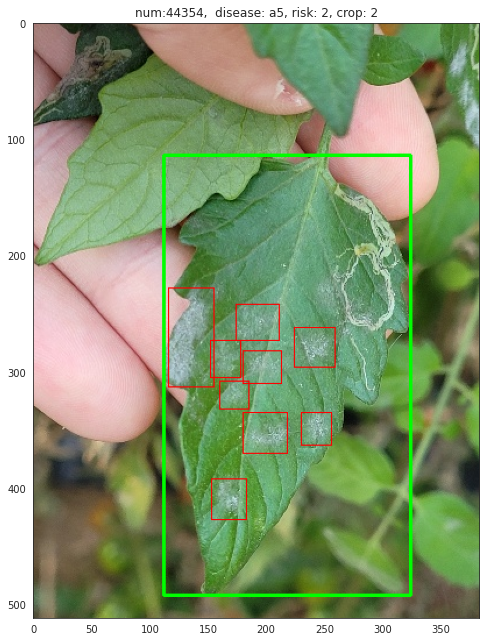

In [20]:
#a = np.random.randint(len(pixel_transform_dataset))
#one = sample[a] 
one = 44354
a=3385

img_path = f"./train/{one}/{one}.jpg"
json_path = f"./train/{one}/{one}.json"
csv_path = f"./train/{one}/{one}.csv"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

draw_img = img.copy()
with open(json_path, 'r') as f:
  data = json.load(f)

object_bbox = data['annotations']['bbox'][0]
cv2.rectangle(draw_img, (int(object_bbox['x']), int(object_bbox['y'])), (int(object_bbox['x'] + object_bbox['w']), int(object_bbox['y'] + object_bbox['h'])),  color = (0,255,0),  thickness = 2 )
error_bbox = data['annotations']['part']

for err in error_bbox:
  cv2.rectangle(draw_img, (int(err['x']), int(err['y'])), (int(err['x'] + err['w']), int(err['y'] + err['h'])), color = (255,0,0), thickness = 1 )

plt.figure(figsize=(8,12))
plt.title(f"num:{one},  disease: {data['annotations']['disease']}, risk: {data['annotations']['risk']}, crop: {data['annotations']['crop']}")

plt.imshow(draw_img)
plt.show()

## Pixel Transform

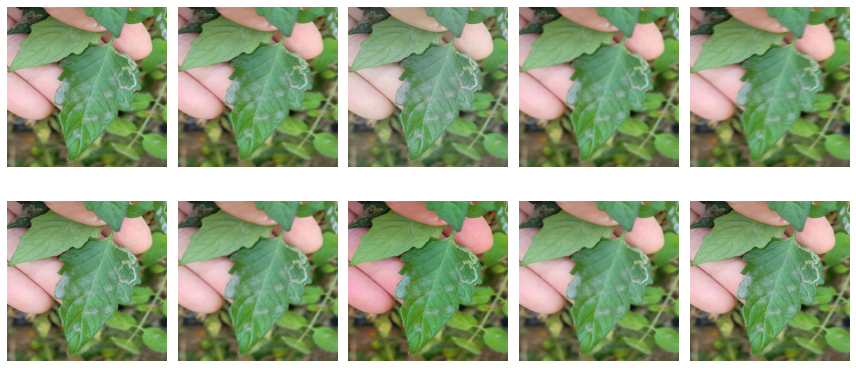

In [21]:
sns.set_style("white")
visualize_augmentations(pixel_transform_dataset, idx = a)

## Spatial Transform

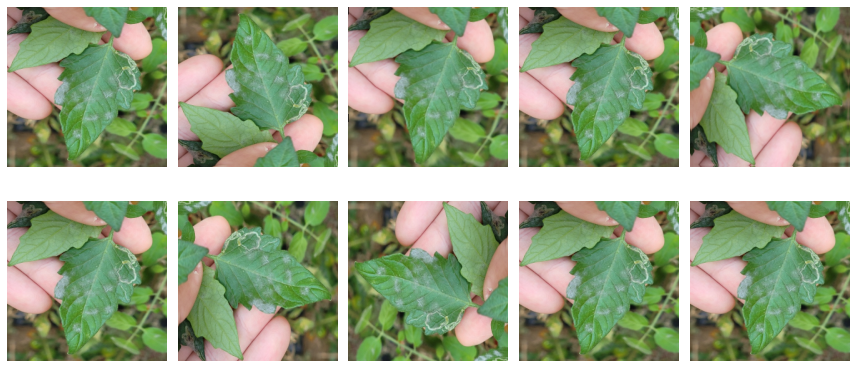

In [22]:
sns.set_style("white")
visualize_augmentations(spatial_transform_dataset, idx = a)


## Pixel_Spatial_Transform

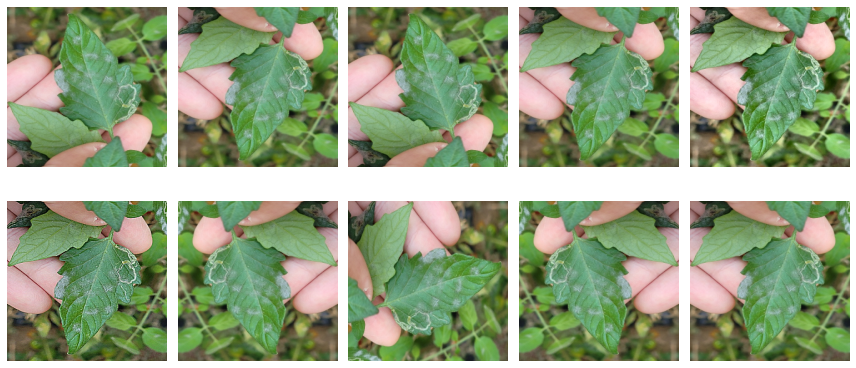

In [24]:
sns.set_style("white")
visualize_augmentations(pixel_spatial_transform_dataset, idx = a)

##  Single image transform(pixel-spatial-transform) + Cutmix

In [91]:
def rand_bbox(size, lam):
  W = size[1]
  H = size[2]
  cut_rat = np.sqrt(1. - lam)
  cut_w = np.int(W * cut_rat)
  cut_h = np.int(H * cut_rat)

  cx = np.random.randint(W)
  cy = np.random.randint(H)

  bbx1 = np.clip(cx - cut_w // 2, 0 ,W)
  bby1 = np.clip(cy - cut_h // 2, 0, H)
  bbx2 = np.clip(cx + cut_w // 2 ,0, W)
  bby2 = np.clip(cy + cut_h // 2, 0, H)

  return bbx1, bby1, bbx2, bby2

cutmix_dataset = copy.deepcopy(pixel_spatial_transform_dataset)
cutmix_dataset.transform = A.Compose([t for t in pixel_spatial_transform_dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
train_loader = DataLoader(dataset = cutmix_dataset, batch_size = 16, shuffle = True, num_workers = 2)

origin : patch = 0.642 : 0.358


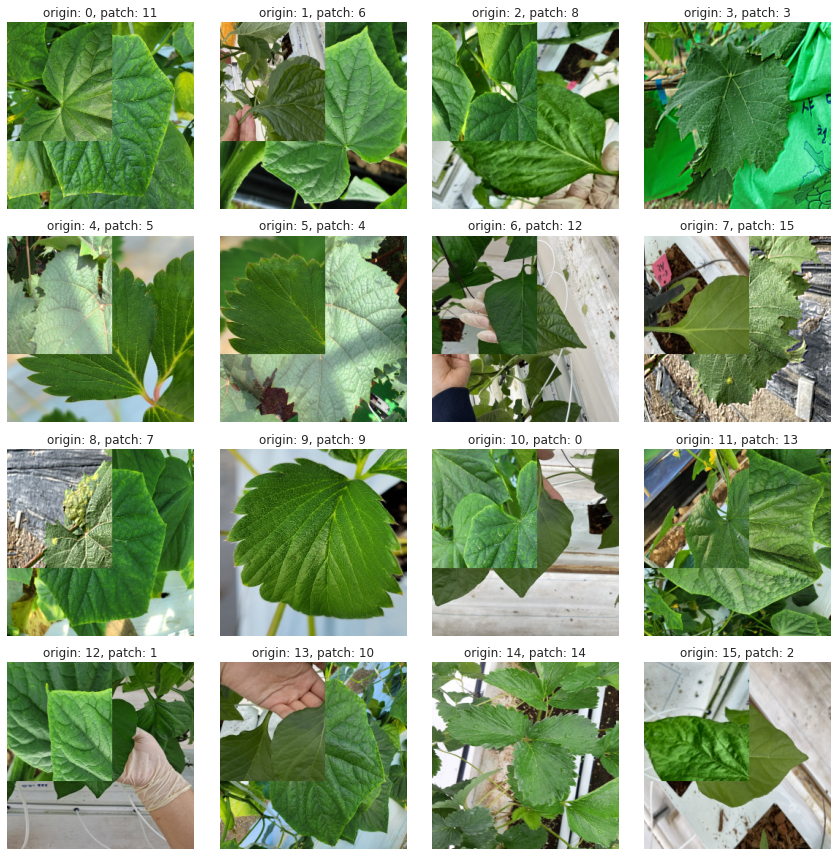

In [100]:
def visualize_cutmix():
    for data in train_loader:
      img = data['img']
      label = data['label']
      
      lam = np.random.beta(0.5, 1.0)
      rand_index = torch.randperm(img.size()[0])

      shuffled_label = label[rand_index]
      bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
      img[:, bbx1:bbx2, bby1:bby2,:] = img[rand_index,bbx1:bbx2, bby1:bby2,:]
      lam = 1- ((bbx2- bbx1) * (bby2-bby1) / (img.size()[1] * img.size()[2]))

      figure, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
      #print(img.shape)
      

      for i in range(16):
        image = np.array(img[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(f"origin: {i}, patch: {rand_index[i]}")
        ax.ravel()[i].set_axis_off()
      
      print(f"origin : patch = {lam:.3f} : {1-lam:.3f}")
      plt.tight_layout()
      plt.show()
      break

visualize_cutmix()